In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

file = '../../archive/YUM.csv'



<h2>Preprocessing</h2>

In [2]:
# Load data into pytorch dataset

from Modules.dataset_class import TimeSeriesDataset
from Modules.preprocess import process_data
X, y, X_train, X_test, y_train, y_test, scaler = process_data(file)
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5904, 30, 1]),
 torch.Size([311, 30, 1]),
 torch.Size([5904, 1]),
 torch.Size([311, 1]))

In [3]:
from torch.utils.data import DataLoader
# create batches
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<h2>Model</h2>

In [4]:
from Modules.model import LSTM

model = LSTM(30, 1, 64, 16, 1)
model.to(device)
model

LSTM(
  (conv1d): Conv1d(30, 1, kernel_size=(1,), stride=(2,))
  (init_linear): Linear(in_features=1, out_features=1, bias=True)
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sequential): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
)

<h2>Training</h2>

In [5]:
from Modules.train import train_model

In [6]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model = train_model(num_epochs, model, loss_function, optimizer, train_loader,test_loader, device)

Epoch: 1
Batch 100, Loss: 0.0240884
Batch 200, Loss: 0.0010678
Batch 300, Loss: 0.0001103

Val Loss: 0.0006958
***************************************************

Epoch: 2
Batch 100, Loss: 0.0001167
Batch 200, Loss: 0.0001900
Batch 300, Loss: 0.0001876

Val Loss: 0.0009052
***************************************************

Epoch: 3
Batch 100, Loss: 0.0001075
Batch 200, Loss: 0.0001273
Batch 300, Loss: 0.0000899

Val Loss: 0.0005536
***************************************************

Epoch: 4
Batch 100, Loss: 0.0000915
Batch 200, Loss: 0.0001275
Batch 300, Loss: 0.0000968

Val Loss: 0.0003340
***************************************************

Epoch: 5
Batch 100, Loss: 0.0000635
Batch 200, Loss: 0.0001183
Batch 300, Loss: 0.0000743

Val Loss: 0.0002112
***************************************************

Epoch: 6
Batch 100, Loss: 0.0000687
Batch 200, Loss: 0.0000605
Batch 300, Loss: 0.0000695

Val Loss: 0.0002973
***************************************************

Epoch: 7
Batch 1

<h2>Output</h2>

In [8]:
split_index = int(len(X) * 0.95)
split_index
lookback = 30

In [9]:
# Split 95% into train, 5% into test

X_test = X[split_index:]
y_test = y[split_index:]


In [10]:

X_test = X_test.reshape((-1, lookback, 1))
y_test = y_test.reshape((-1, 1))


In [11]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_test.shape, y_test.shape

(torch.Size([311, 30, 1]), torch.Size([311, 1]))

In [12]:
# outmodel = LSTM(30, 1, 64, 16, 1)
outmodel = torch.load('forcast.pt')
outmodel.eval()

LSTM(
  (conv1d): Conv1d(30, 1, kernel_size=(1,), stride=(2,))
  (init_linear): Linear(in_features=1, out_features=1, bias=True)
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sequential): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): LSTM(1, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
)

In [13]:
# with torch.no_grad():
#     predicted = outmodel(X_train.to(device)).to('cpu').numpy()

# plt.plot(y_train, label='Actual Close')
# plt.plot(predicted, label='Predicted Close')
# plt.xlabel('Day')
# plt.ylabel('Close')
# plt.legend()
# plt.show()


In [14]:
# train_predictions = predicted.flatten()

# dummies = np.zeros((X_train.shape[0], lookback+1))
# dummies[:, 0] = train_predictions
# dummies = scaler.inverse_transform(dummies)

# train_predictions = dc(dummies[:, 0])
# train_predictions

In [15]:
# dummies = np.zeros((X_train.shape[0], lookback+1))
# dummies[:, 0] = y_train.flatten()
# dummies = scaler.inverse_transform(dummies)

# new_y_train = dc(dummies[:, 0])
# new_y_train

In [16]:
# plt.plot(new_y_train, label='Actual Close')
# plt.plot(train_predictions, label='Predicted Close')
# plt.xlabel('Day')
# plt.ylabel('Close')
# plt.legend()
# plt.show()


In [17]:
test_predictions = outmodel(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([114.17661812, 114.32922617, 114.52023869, 114.50606943,
       114.62406378, 114.67592423, 114.13457517, 114.02417035,
       114.26797298, 114.80533894, 115.32905658, 115.81077935,
       115.95232769, 116.54972868, 116.97035053, 117.2397027 ,
       117.62284974, 117.08259062, 116.20708585, 115.91447621,
       116.0334483 , 115.92684226, 116.06470402, 115.98060209,
       116.28735695, 116.3980583 , 116.70986215, 116.9243405 ,
       117.03696528, 117.1426577 , 117.17610933, 117.18170331,
       116.99916189, 116.74194334, 116.59238873, 116.3616013 ,
       116.4303158 , 116.02333427, 116.12130893, 116.42844046,
       116.16345607, 116.16503488, 116.02371896, 115.56070153,
       114.63434611, 114.6563854 , 114.83694729, 114.79423114,
       114.79675564, 114.86752981, 114.57374207, 114.23278224,
       113.85023627, 113.88226137, 114.15689496, 114.12655287,
       114.57911165, 114.7033892 , 115.16263991, 115.23694036,
       115.07720761, 114.98876995, 114.88700453, 114.49

In [18]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
# new_y_test

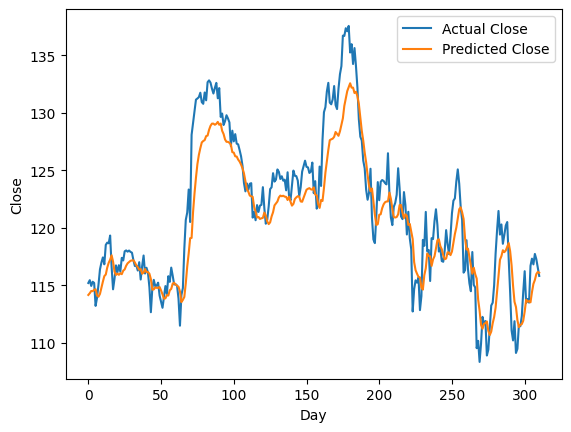

In [19]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


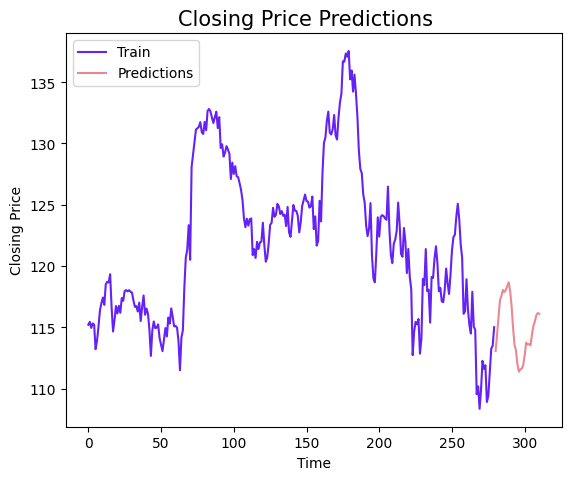

In [20]:
def plot_model_predictions(test, preds):
    plot_test = pd.DataFrame(data=test, index=range(test_predictions.size), columns=['Close'])
    plot_test['Day'] = plot_test.index
    plot_test = plot_test[:int(np.ceil(len(plot_test) * 0.9))]
    plot_pred = pd.DataFrame(data=preds, index=range(new_y_test.size), columns=['Predictions'])
    plot_pred['Day'] = plot_pred.index
    plot_pred = plot_pred[int(np.ceil(len(plot_pred) * 0.9)):]

    # fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    # axes[2][1].set_visible(False)
    
    plt.suptitle('Closing Price Predictions', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 15)

    # plt.facecolor('black')
    plt.plot(plot_test['Day'], plot_test['Close'], color = '#6522F5', label = 'Train')
    plt.plot(plot_pred['Day'], plot_pred['Predictions'], color = '#EB8791', label = 'Predictions')
    # plt.set_title('Meta', fontsize = 30)
    plt.xlabel('Time', fontsize = 10)
    plt.ylabel('Closing Price', fontsize = 10)
    # plt.xaxis.set_tick_params(labelsize = 18)
    # plt.yaxis.set_tick_params(labelsize = 18)
    plt.legend(loc = 'upper left', fontsize = 10)
    
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
plot_model_predictions(new_y_test, test_predictions)